### 5. DBSCAN(Density Based Spatial Clustering of Applications with Noise)

#### DBSCAN 개요
- 밀도 기반 군집화의 대표적 알고리즘
- 간단하고 직관적 알고리즘
- 데이터 분포가 기하학적으로 복잡한 데이터 세트에도 효과적 군집화 가능
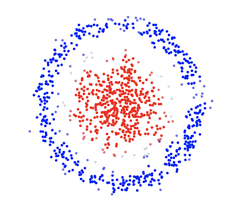

- K평균, 평균 이동, GMM은 위 그림과 같이 외부 원, 내부 원 형태의 분포를 가진 데이터 세트를 효과적으로 군집화하기 어려움
- DBSCAN은 특정 공간 내 데이터 밀도 차이를 기반 알고리즘으로 하기 때문에 복잡한 기하 분포도 가진 데이터에 대해서도 군집화 잘 수행함

- DBSCAN의 중요한 파라미터
    1. 입실론(epsilon) 주변 영역 : 개별 데이터 중심으로 입실론 반경을 가지는 원형의 영역
    2. 최소 데이터 개수(min points) : 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수

        
- 입실론 주변 영역 내 포함되는 최소 데이터 개수를 충족시키는가 아닌가에 따라 데이터 포인트 정의
    - 핵심 포인트(Core Point) : 주변 영역 내 최소 데이터 개수 이상의 타 데이터 가지고 있을 경우
    - 이웃 포인트(Neighbor Point) : 주변 영역 내 위치한 타 데이터
    - 경계 포인트(Border Point) : 주변 영역 내 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만 핵심 포인트를 이웃 포인트로 가지고 있는 데이터
    - 잡음 포인트(Noise Point) : 최소 데이터 개수 이상의 이웃 포인트 가지고 있지 않으며, 핵심 포인트도 이웃 포인트로 가지고 있지 않은 데이터
        

1. P1에서 P12까지 12개의 데이터 세트에 대해 DBSCAN 군집화를 적용
- 특정 입실론 반경 내에 포함될 최소 데이터 세트를 6개(자기 자신 포함)로 가정
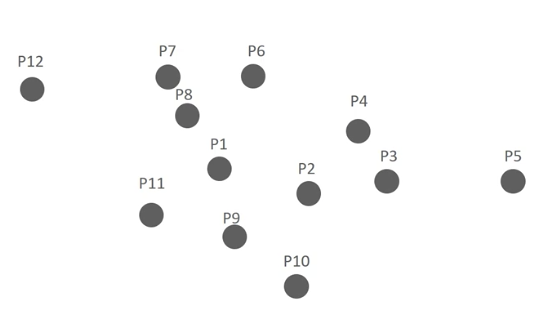
2.P1 데이터를 기준으로 입실론 반경 내에 포함된 데이터가 7개 (자신은 P1, 이웃은 P2, P6, P7, P8, P9, P11)로 최소 데이터 5개 이상을 만족하므로 P1 데이터는 핵심 포인트(Core Point)
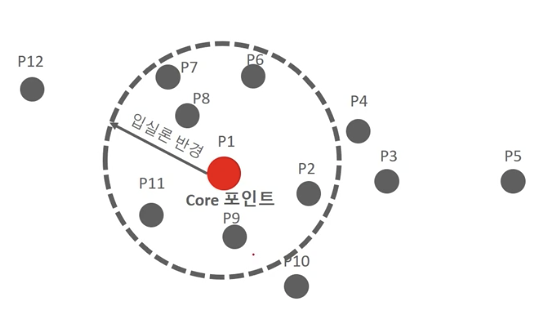
3. P2 데이터 역시 반경 내에 6개의 데이터(자신은 P2, 이웃 데이터 P1, P3, P4, P9, P10)를 갖고 있으므로 핵심 포인트
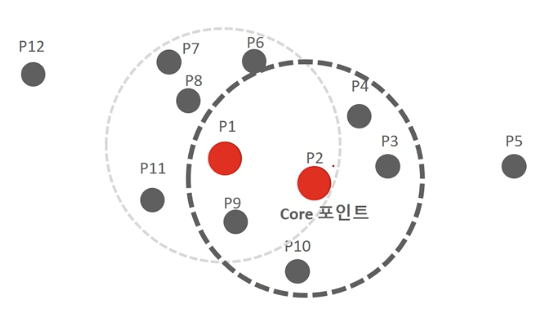

4.핵심 포인트 P1의 이웃 데이터 포인트 P2 역시 핵심 포인트이므로 P1에서 P2로 연결해 직접 접근 가능  특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화를 구성. 이러한 방식으로 점차적으로 군집(Cluster) 영역을 확장해 나감
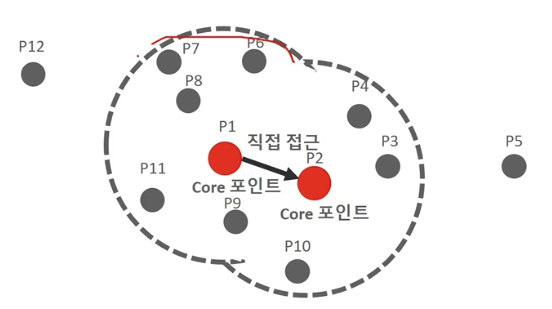
5. P3 데이터의 경우 반경 내에 포함되는 이웃 데이터는 P2, P4 2개 뿐이므로 군집으로 구분할 수 있는 핵심 포인트가 될 수 없지만 이웃 데이터 중 핵심 포인트인 P2를 갖고 있음. 이처럼 자신은 핵심 포인트가 아니지만, 이웃 데이터로 핵심 포인트를 갖고 있는 데이터를 경계 포인트(Border Point)라고 합니다. 경계 포인트는 군집 외곽을 형성
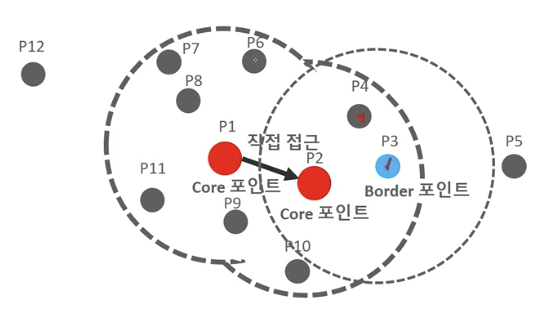
6. P5와 같이 반경 내에 최소 데이터를 갖고 있지도 않고, 핵심 포인트 또한 이웃 데이터로 갖고 있지 않는 데이터를 잡음 포인트(Noise Point)라고 함
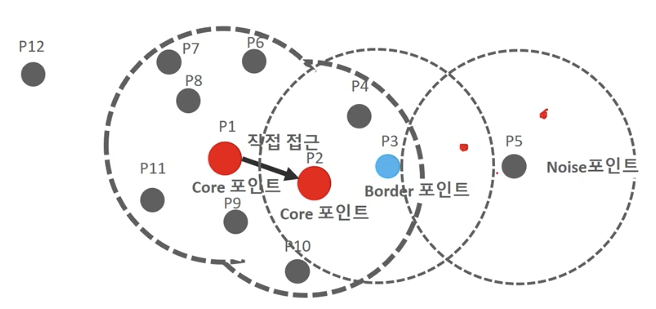

#### DBSCAN 적용하기 – 붓꽃 데이터 셋

In [1]:
from sklearn.datasets import load_iris 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [2]:
from sklearn.cluster import DBSCAN # 사이킷런 DBSCAN 클래스
# DBSCAN은 군집 개수를 알고리즘에 따라 자동 지정하므로,
# 특정 군집 개수를 강제하는 것 보다 eps 와 min_samples 파라미터를 통해 최적의 군집을 찾는 것이 중요함
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)
# -1 : 노이즈에 속하는 군집

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64


In [3]:
# 군집 수행 객체를 입력 받아 시각화하는 함수 
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


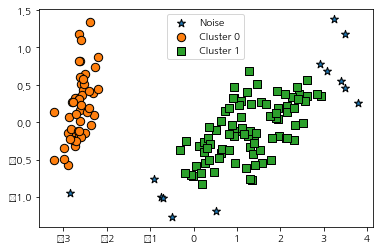

In [4]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처로 데이터 압축 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)
# 2차원으로 시각화 -> 이상치인 Noise 데이터가 명확히 보임

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: dbscan_cluster, dtype: int64


C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


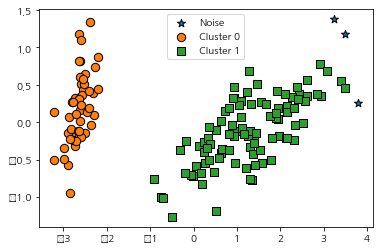

In [5]:
from sklearn.cluster import DBSCAN
# 일반적으로 eps값이 크면 반경이 커져 포함하는 데이터가 많아지므로 노이즈 데이터 개수가 적어짐
# min_samples를 크게 하면 주어진 반경 내 더 많은 데이터를 포함시켜야 하므로 노이즈 데이터 개수가 커짐
# eps 0.6 -> 0.8 로 증가
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)
# 노이즈 군집이 3개밖에 없는 것을 확인할 수 있음

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: dbscan_cluster, dtype: int64


C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


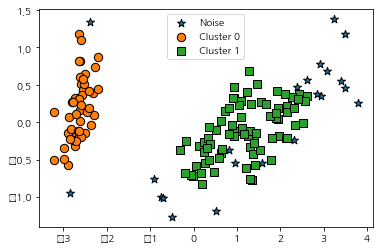

In [6]:
# eps 0.6 유지 , min_samples 16으로 늘림
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)
# 노이즈 데이터가 기존보다 많이 증가한 것을 확인할 수 있음

#### DBSCAN 적용하기 – make_circles() 데이터 세트
- 복잡한 기하학적 분포 갖는 데이터 세트에서 DBSCAN과 타 알고리즘 비교하기

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


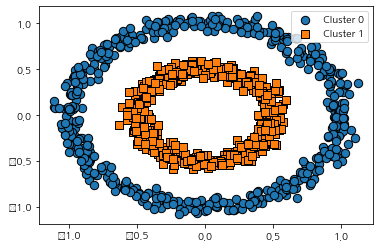

In [7]:
from sklearn.datasets import make_circles
# 내부 원과 외부 원 형태로 돼 있는 2차원 데이터 세트 만들기 
X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


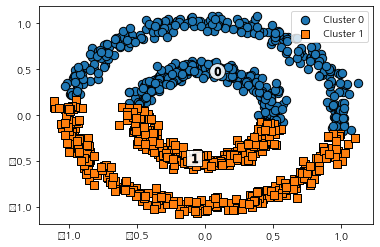

In [8]:
# K-평균으로 클러스터링 수행. 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)
# 위, 아래 군집 중심을 기반으로 위와 아래 절반으로 군집화됨
# 거리 기반 군집화로는 위와 같은 데이터가 특정한 형태로 지속해서 이어지는 부분을 찾아내기 어려움

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


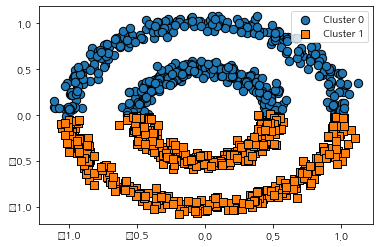

In [9]:
# GMM으로 클러스터링 수행. 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)
# GMM도 일렬로 늘어선 데이터 세트에서는 효과적 군집화 적용이 가능했으나, 
# 내부와 외부 원형으로 구성된 복잡한 형태의 데이터 세트에서는 군집화가 원하는 방향으로 되지 않음

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


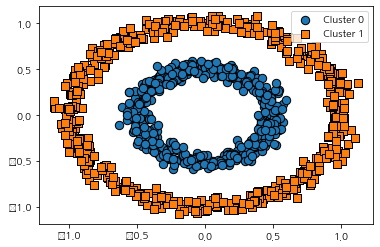

In [10]:
# DBSCAN으로 클러스터링 수행. 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)
# 원하는 방향으로 군집화 수행됨